# 3. Aligning data and attempt to fix HRI EUV pointing
In this part of the tutorial we're going to align images from different instruments using the available WCS metadata in the FITS files. We will use data from March 6, 2022 when Solar Orbiter was on the Sun-Earth line, and look at images from FSI, HRI EUV and HRI LYA compared to eachother and to SDO AIA data taken around the same time.

In the second part of this notebook we will try to automatically improve on the HRI EUV and FSI alignment by iteratively minimizing scaled difference images.

We will again start with importing the packages we are using in this tutorial

In [1]:
%matplotlib notebook
import astropy.units as u
from matplotlib import animation
from IPython.display import HTML

import matplotlib.pyplot as plt
import sunpy.map
import numpy as np

from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

from reproject import reproject_interp

from sunpy.map.maputils import solar_angular_radius

# We like big figures and we cannot lie..!
plt.rcParams['figure.figsize'] = [10, 10]


Let's start with looking at some SDO AIA 171 data compared to FSI 174 data. We will use FSI L2 data which (all L2 is limb-fitted) and compare this to SDO AIA L1 data. We'll create some helper function to quickly investigate the quality of the pointing meta-data in the FITS files.

In [2]:
def submap(m, c1,c2, radius):
    """ Returns a subfielded SunPy map around some center coordinates with a specified radius """
    top_right = SkyCoord((c1 + radius) * u.arcsec, (c2 + radius) * u.arcsec, frame=m.coordinate_frame)
    bottom_left = SkyCoord((c1 -radius) * u.arcsec, (c2  -radius) * u.arcsec, frame=m.coordinate_frame)
    return m.submap(bottom_left, top_right=top_right)

def openSubmap(filename, c1=0,c2=0, radius=None):
    """ Opens a filename as a (subfielded) SunPy map. If radius is None, it plots up to 1.2 solar radii  """
    m = sunpy.map.Map(filename)
    if radius is None:
        radius = 1.2 * solar_angular_radius(m.coordinate_frame) / u.arcsec
    return submap(m, c1,c2, radius)

def plotTwo(m1,m2):
    """ Plot two SunPy maps side by side"""
    fig = plt.figure()
    ax1 = fig.add_subplot(211, projection=m1)
    m1.plot()
    
    m1.draw_grid(axes=ax1, system='stonyhurst')

    ax2 = fig.add_subplot(212, projection=m2)
    m2.plot()
    m2.draw_grid(axes=ax2, system='stonyhurst')

def plotLimb(m):
    """ Plots four quadrants of a SunPy map"""
    fig = plt.figure()
    r = solar_angular_radius(m.coordinate_frame) / u.arcsec
    subplotc1c2s = ((221, 0, r), (222, 0, -r), (223, r,0), (224,-r,0))
    for subplotc1c2 in subplotc1c2s:
        m1 = submap(m, subplotc1c2[1], subplotc1c2[2], r // 4)
        ax1 = fig.add_subplot(subplotc1c2[0], projection=m1)
        m1.plot()
        m1.draw_grid(axes=ax1, system='stonyhurst')
        m1.draw_limb()
    

We will have a closer look at an L1 FSI 174 image of March 6, 2022. This FITS file will have pointing metadata using the spacecraft pointing information, but as we've seen in a previous notebook, we don't expect this information to be very accurate.

<IPython.core.display.Javascript object>


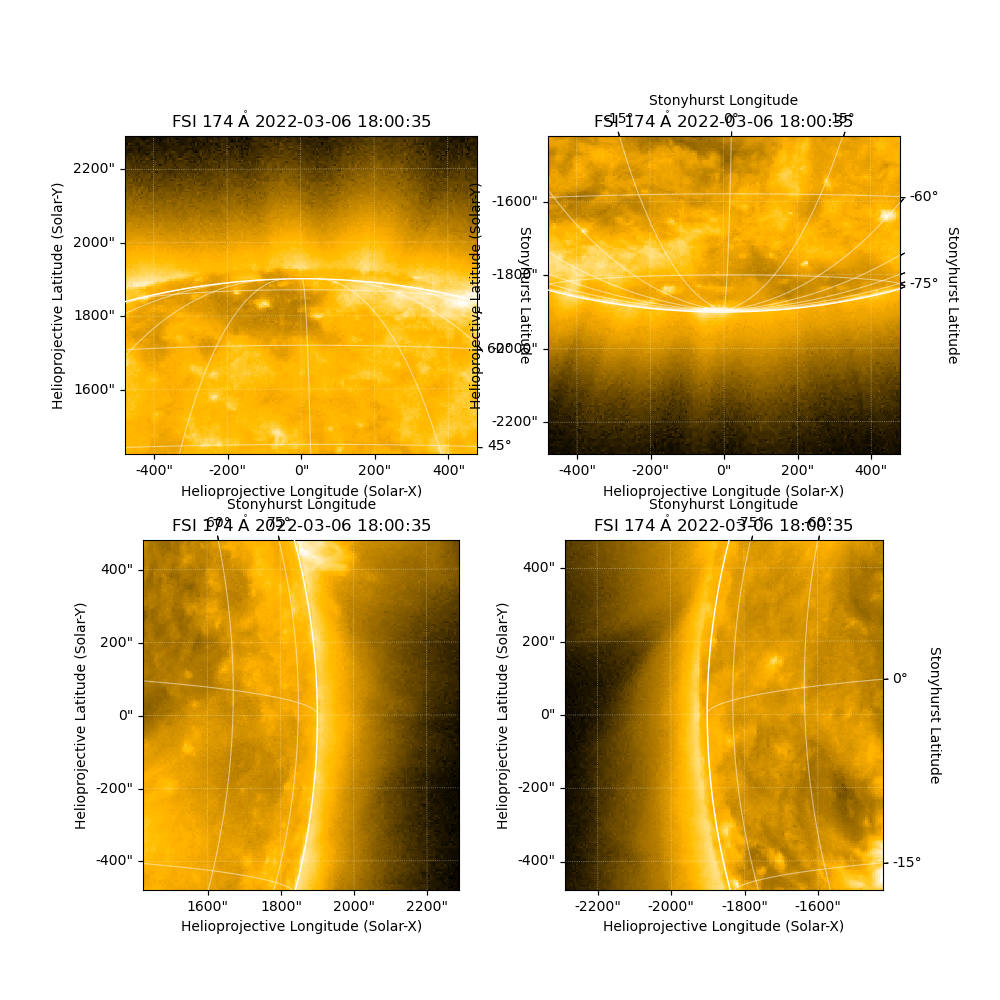

In [3]:
m1 = openSubmap('./data_align/solo_L1_eui-fsi174-image_20220306T180030298_V01.fits')
plotLimb(m1)



Indeed the pointing information appears to be off be by perhaps 15 arc seconds. Now if we compare this to the L2 version of this image, limb-fitting should have updated this pointing information and fix the issue.

In [4]:
m2 = openSubmap('./data_align/solo_L2_eui-fsi174-image_20220306T180030298_V01.fits')
m2.meta['HISTORY']

'created by /home/eui/pipeline/telemetry_parser.py --databaseExternal --workingDirectory /tmp/telemetry_parser --configFile /home/eui/config/config.ini --outputDirectory /data/solo-eui/internal/L0/ --atROBcreated by /home/eui/pipeline/level0_to_level1_release.py --inputL0 /home/eui/pipeline/new_release/release5/xag.txt --outputReleaseList /home/eui/pipeline/new_release/release5/output_xag.txt --configFile /home/eui/config/config.ini -od /data/solo-eui/internal/releases/202204_release_5.0/L1/euiprep.py (L1 to L2), UTC time: 2022-04-13T16:31:39S/W git version: 9fd9271230a2c6e432290e383a816032ea7d600aPointing updated with: CRVAL1=91.901956, CRVAL2=1992.996460, EUXCEN=1516.938762, EUYCEN=1085.810382, attempt=1, tolerance=0.000030Image normalized by integration time.Image rectified using: order 1, optical.Last 32 columns removed.'

Looking at the history metadata, we can indeed see that the Pointing was updated. This message should be visible for all FSI solar images that are normally exposed and have the solar limb visible.

<IPython.core.display.Javascript object>


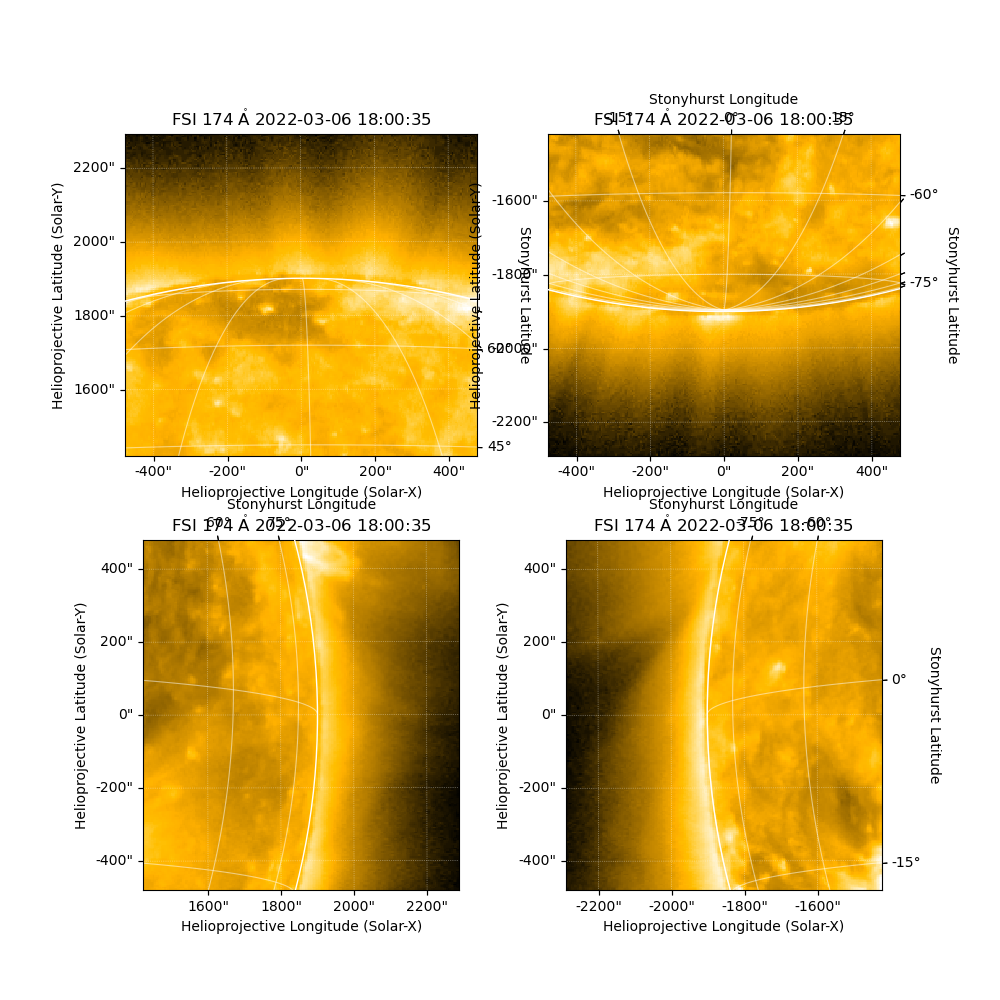

In [5]:
plotLimb(m2)

And plotting the limb of this L2 file, shows us that indeed the pointing information now appears to be accurate.

Now we will open some AIA data taken around the same time (2 seconds difference) and display this next to the FSI 174 L2 data.

<IPython.core.display.Javascript object>


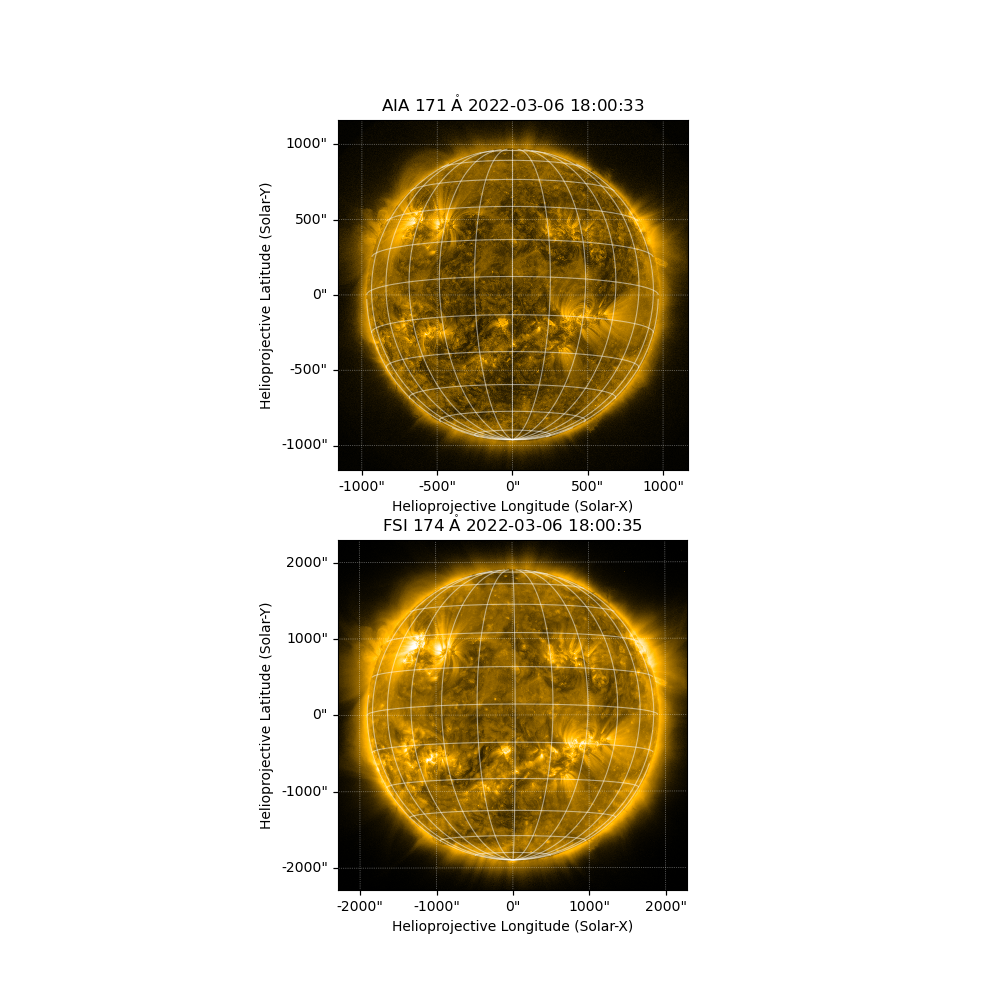

In [6]:
aiam = openSubmap('./data_align/AIA.20220306_180033.0171.image_lev1.fits')
plotTwo(aiam,m2)


We can see that the viewpoint from both satellites is very similar, but it is not quite the same: AIA sees more of the south pole of the Sun, and also sees a little bit more of the western limb. Still, these images should be very comparable when reprojected to the same observer. Let's verify this.

First we will create a new function that compares two maps by reprojecting the first map to the view of the second map. We can then animate the resulting images to 'blink' between the two maps and quickly see if the pointing metadata in the FITS files is accurate!


In [7]:
import sunpy.visualization.colormaps as cm
from matplotlib.colors import PowerNorm

# compare f1 to f2 (rescale f1 to f2)
def compare(m1, m2, filename_gif):
    output, footprint = reproject_interp(m1, m2.wcs, m2.data.shape)
    # Create a new map from this output using the WCS meta-data from the second map
    m1_2 = sunpy.map.Map(output, m2.wcs)
    d1_2 = m1_2.data.astype(np.float32)
          
    d1_2[np.isnan(d1_2)] = 0
    m1_2 = sunpy.map.Map(d1_2, m1_2.meta)

    # Create the figure
    fig = plt.figure()
    # Provide the Map as a projection, which creates a WCSAxes object
    ax = plt.subplot(projection=m2)

    # Build the images for the animation
    ims = []
    m1_2.plot_settings['norm'] = PowerNorm(0.3)
    im1 = m1_2.plot(axes=ax, clip_interval=(1, 99.9)*u.percent, cmap=plt.get_cmap('sdoaia171'))#, cmap=plt.get_cmap('sdoaia171'))
    ims.append([im1])
    im2 = m2.plot(axes=ax, clip_interval=(1, 99.9)*u.percent)
    ims.append([im2])
    
    ani = animation.ArtistAnimation(fig, ims, interval=1000, blit=True, repeat_delay=0)
    writergif = animation.PillowWriter(fps=2) 
    ani.save(filename_gif, writer=writergif)

To speed things up, we will not reproject the entire image, but work with a submap that is slightly bigger than the Sun (and has the Sun centered).

<IPython.core.display.Javascript object>


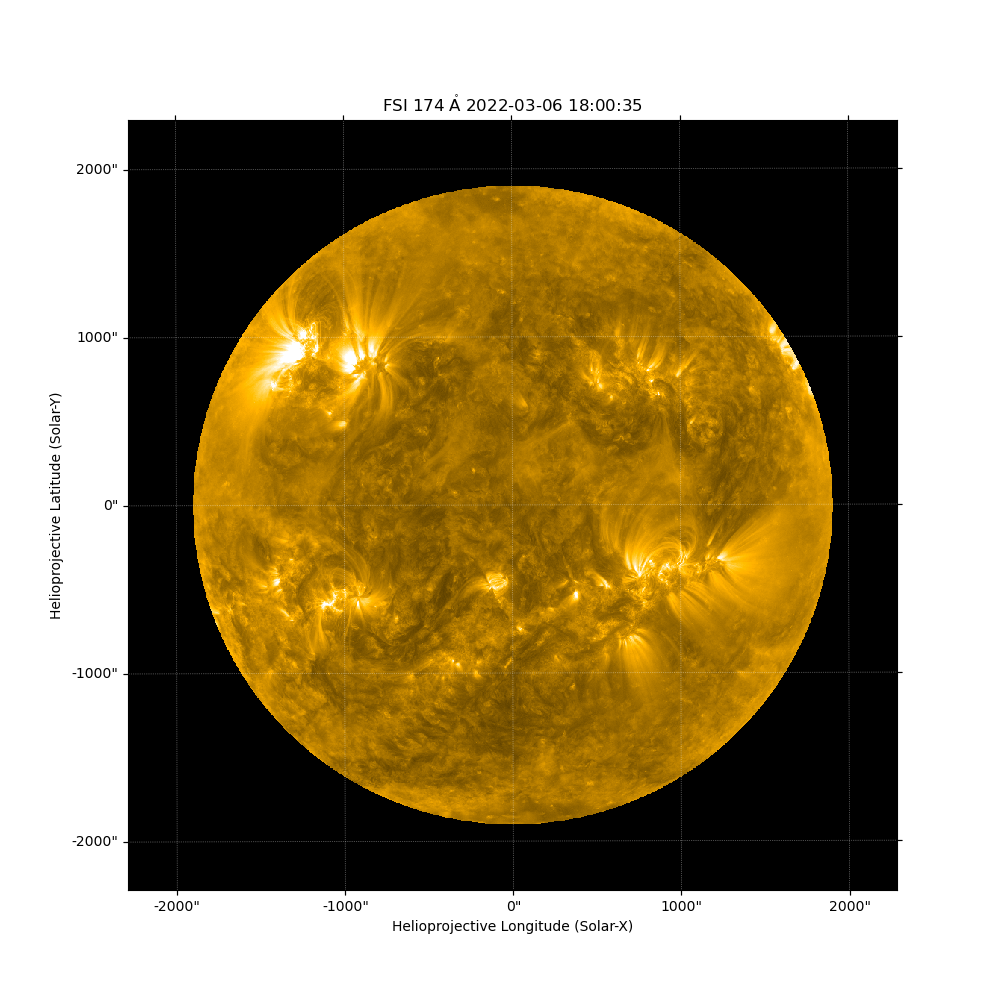

In [8]:
f1 = './data_align/AIA.20220306_180033.0171.image_lev1.fits'
f2 = './data_align/solo_L2_eui-fsi174-image_20220306T180030298_V01.fits'

m1 = openSubmap(f1)
m2 = openSubmap(f2)
compare(m1,m2, 'aia_vs_fsi.gif')


![SegmentLocal](aia_vs_fsi.gif "segment")

As expected the L2 FSI alignment looks very good when compared to the SDO AIA file. There are some projection artifacts due to the differing viewpoints between SDO and Solar Orbiter, but the error appers very small. Note that the title of the animation incorrectly does not show that the reprojected image (the one without the solar corona visible) is in fact the SDO AIA image.

Now we can compare the L2 FSI image with an L2 HRI EUV image taken at the same time.

<IPython.core.display.Javascript object>


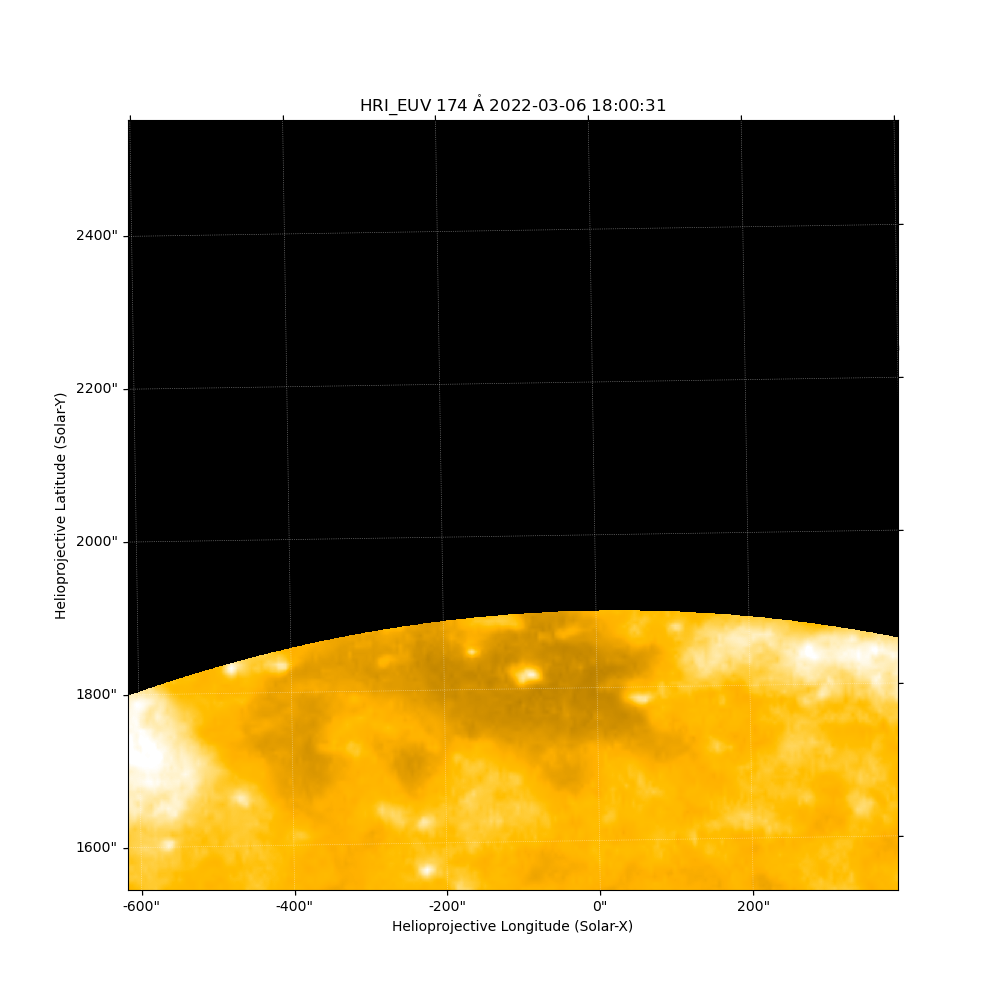

In [9]:
f1 = './data_align/solo_L2_eui-fsi174-image_20220306T180030298_V01.fits'
f2 = './data_align/solo_L2_eui-hrieuv174-image_20220306T180030294_V01.fits'

compare(sunpy.map.Map(f1), sunpy.map.Map(f2), 'fsi_vs_hrieuv.gif')


![SegmentLocal](fsi_vs_hrieuv.gif "segment")


You can see that the alignment between FSI and HRI EUV is not that good, there is a jump of about 20 arc seconds. This is because the L2 FSI images have limb-fitting applied to accurately find the coordinates of the Sun in the image, whilst for L2 HRI EUV (and HRI LYA) images, the coordinates are copied directly from L1 files. And as we have seen before, there are thermo-elastic effects that causes the boresights of our telescopes to drift in comparison to the space craft boresight (which is used to create the pointing information inside the L1 files).

Now let's have a look at HRI LYA and HRI EUV.

<IPython.core.display.Javascript object>


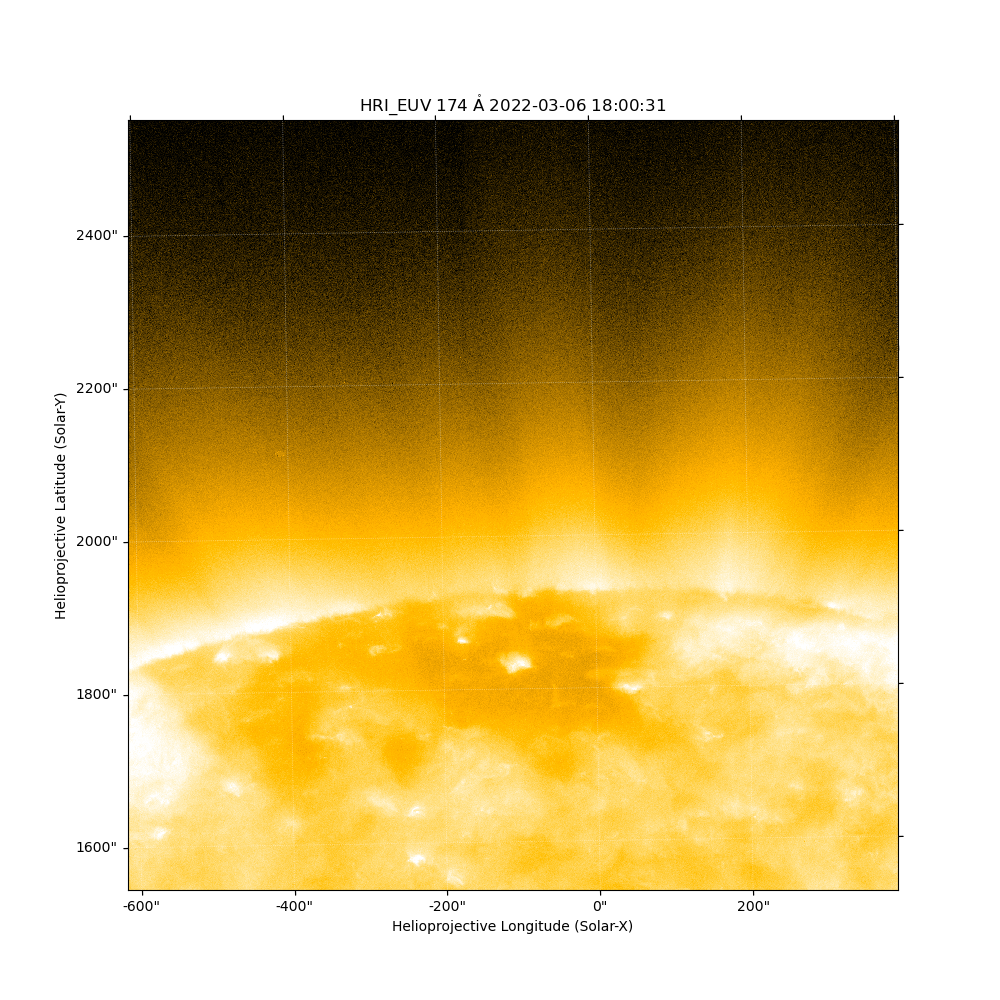

In [10]:
f1 = './data_align/solo_L2_eui-hrilya1216-image_20220306T180030287_V01.fits'
f2 = './data_align/solo_L2_eui-hrieuv174-image_20220306T180030294_V01.fits'
compare(sunpy.map.Map(f1), sunpy.map.Map(f2), 'hrilya_vs_hrieuv.gif')

![SegmentLocal](hrilya_vs_hrieuv.gif "segment")

The alignment between HRI LYA and HRI EUV seems pretty good.

## Basic attempt to correct misalignment
As a small exercise, let's see if we can correct for the misalignment between FSI and HRI EUV. We will direcly alter the CRVAL keywords inside the HRI EUV keywords, create new SunPy maps using those values, and try to minimize the difference between reprojected HRI EUV and FSI data.

We will first look at a reprojected FSI image next to the HRI EUV image.

<IPython.core.display.Javascript object>


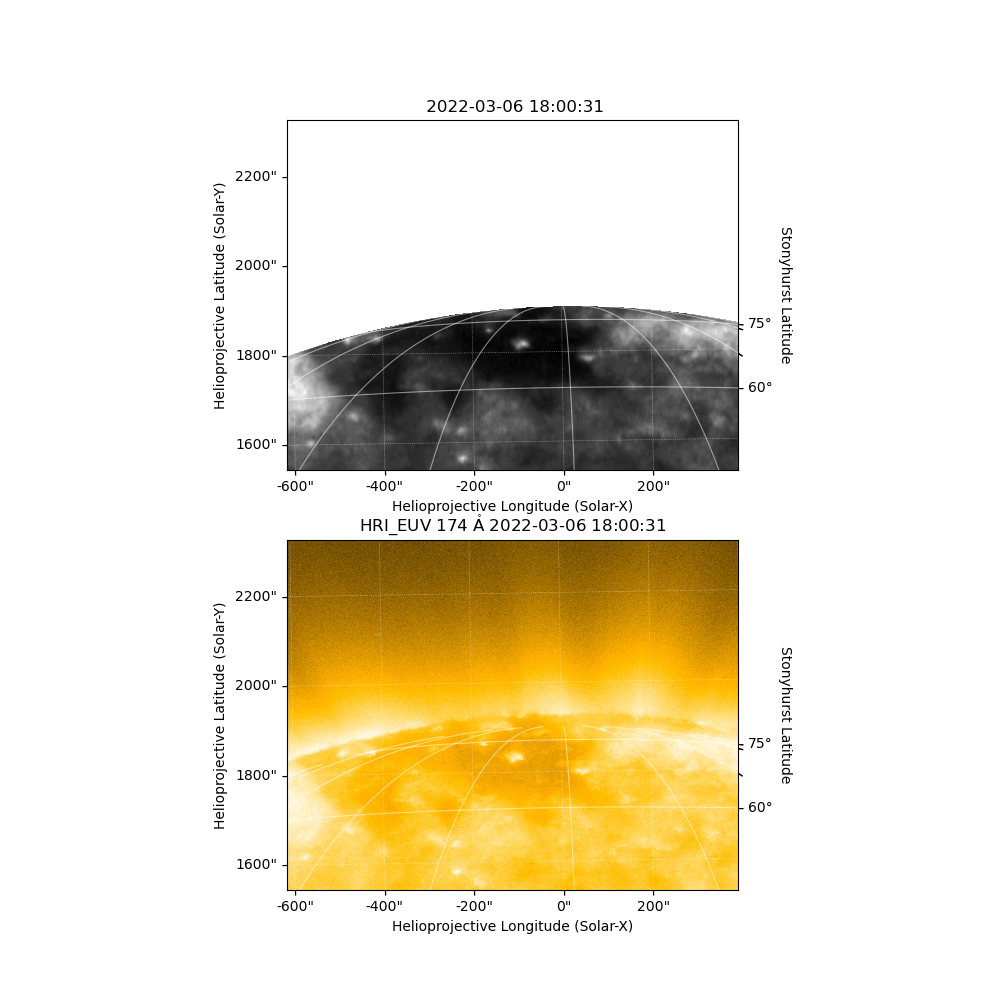

In [11]:
mfsi = openSubmap('./data_align/solo_L2_eui-fsi174-image_20220306T180030298_V01.fits')
mhri = openSubmap('./data_align/solo_L2_eui-hrieuv174-image_20220306T180030294_V01.fits')

output, footprint = reproject_interp(mfsi, mhri.wcs, mhri.data.shape)
mfsi_reprojected = sunpy.map.Map(output, mhri.wcs)

plotTwo(mfsi_reprojected, mhri)


We should make the image intensities between FSI and HRI EUV comparable by dividing the images by their mean intensities. This could open up the door for an automated way to brute-force our way into better pointing accuracy. This would only work accurately if we looked at the same area of the image though, so we will focus on a small part of the image with some interesting features visible.


<IPython.core.display.Javascript object>


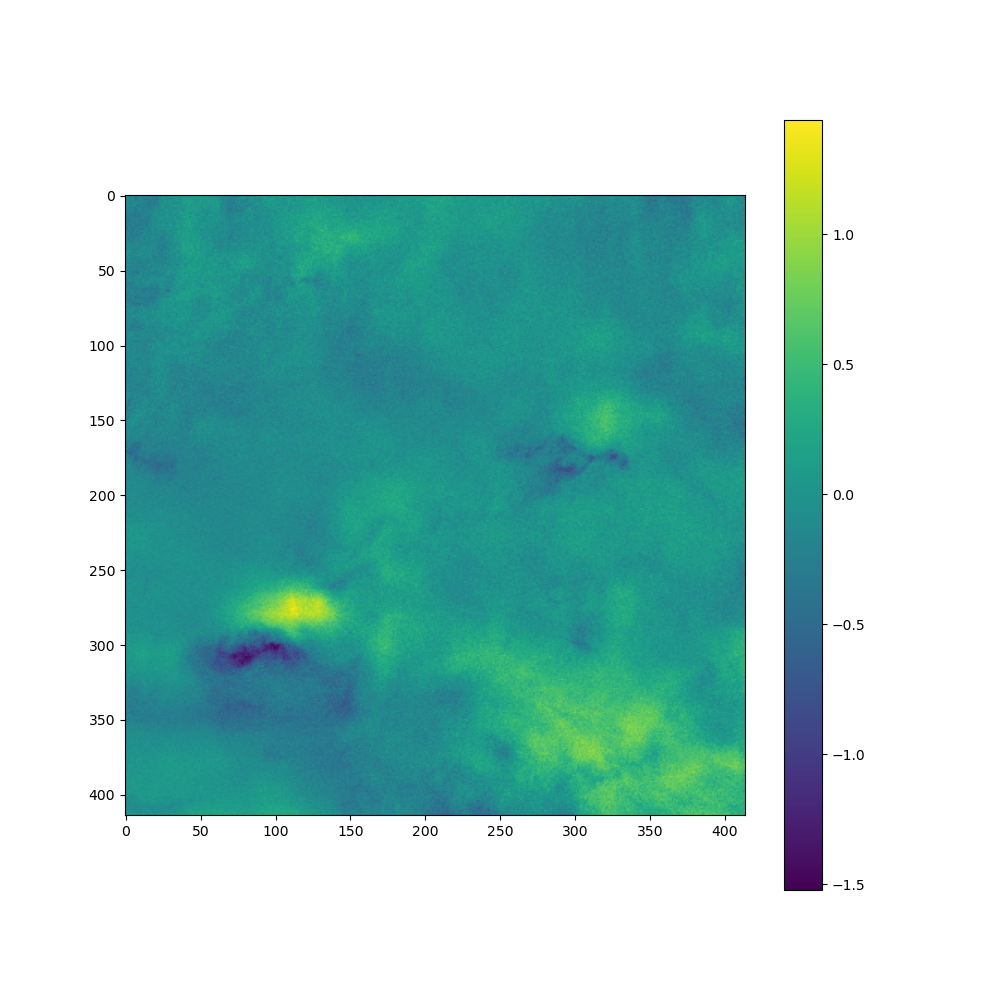

In [12]:
mfsi = openSubmap('./data_align/solo_L2_eui-fsi174-image_20220306T180030298_V01.fits', 100, 1750, 150)
mhri = openSubmap('./data_align/solo_L2_eui-hrieuv174-image_20220306T180030294_V01.fits', 100, 1750, 100)

output, footprint = reproject_interp(mfsi, mhri.wcs, mhri.data.shape)
mfsi_reprojected = sunpy.map.Map(output, mhri.wcs)

diff = (mfsi_reprojected.data / np.median(mfsi_reprojected.data)) - (mhri.data / np.median(mhri.data))
plt.figure()
plt.imshow(diff)
plt.colorbar()


The difference image shows us that indeed the alignment is indeed not correct.

We will write a function that tries specific CRVAL offset values, and returns a normalized difference image using those CRVAl offsets. A better matching CRVAL value should give us a more uniform difference image, and for eample the sum of the absolute difference image could be used as a measurement for how well aligned the images are.

As explained above, we can speed things up a bit by only looking at a small part of the image. We're going to use a part that has some recognizable features in them and is fully on-disc. Even though the FSI image will be of much lower resolution than the HRI EUV image, this technique could still work as large gradients within the image should show similar intensity values. 

In [13]:
def compareImages(filename_fsi, filename_hri, offset_crval1, offset_crval2):
    mfsi = openSubmap(filename_fsi, 100, 1750, 150)

    # The EUI images are compressed.
    # When opening these image with astropy.io.fits, the actual images are in the last header data unit.
    hdu_hri = fits.open(filename_hri) 
    hdu_hri[-1].header['CRVAL1'] += offset_crval1
    hdu_hri[-1].header['CRVAL2'] += offset_crval2    
    mymap = sunpy.map.Map((hdu_hri[-1].data, hdu_hri[-1].header))
    mhri = submap(mymap, 100, 1750, 100)
                  
    # Reprojecting is quite slow..
    output, footprint = reproject_interp(mfsi, mhri.wcs, mhri.data.shape)
    mfsi_reprojected = sunpy.map.Map(output, mhri.wcs)
    
    d_fsi = mfsi_reprojected.data / np.median(mfsi_reprojected.data)
    d_hri = mhri.data / np.median(mhri.data)
    diff = d_fsi - d_hri
    return diff, d_fsi, d_hri


We can run this on our two images, and have a peek at the resulting difference image when trying a new CRVAL value.

<IPython.core.display.Javascript object>


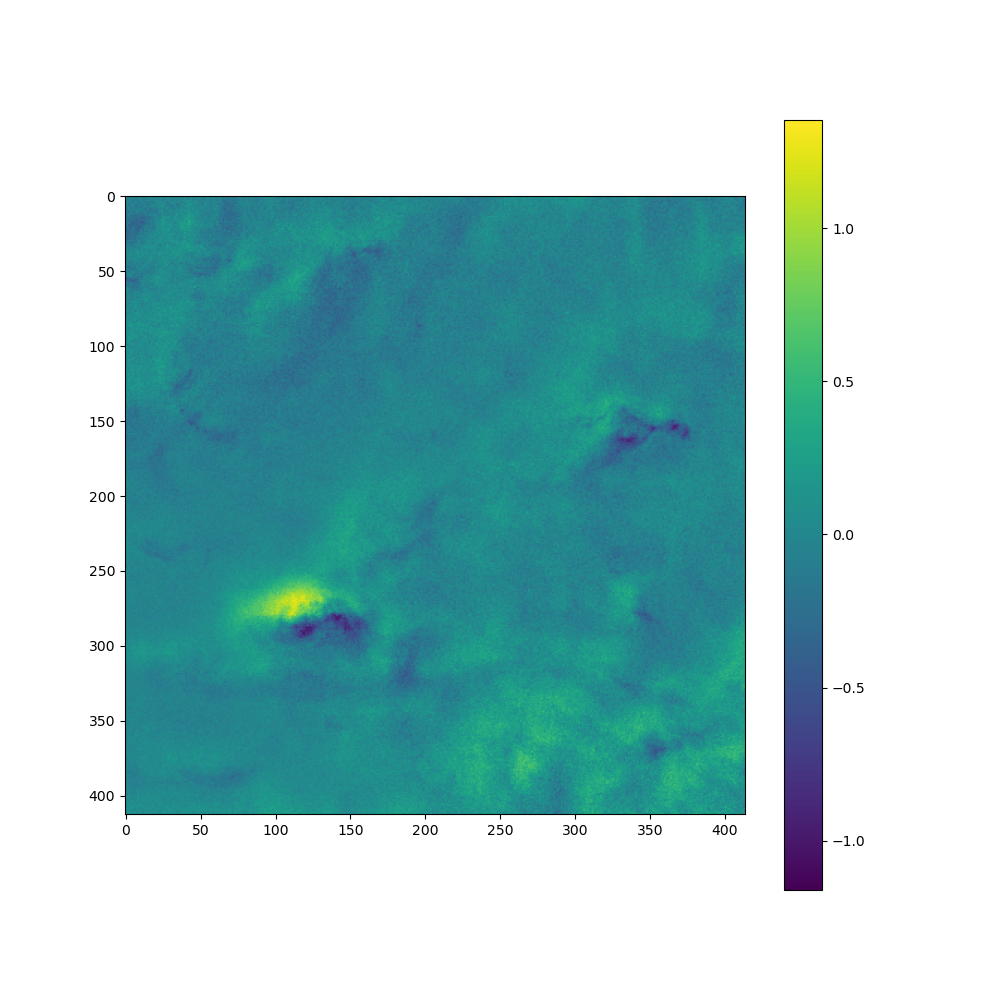

In [14]:
from astropy.io import fits

filename_fsi = './data_align/solo_L2_eui-fsi174-image_20220306T180030298_V01.fits'
filename_hri = './data_align/solo_L2_eui-hrieuv174-image_20220306T180030294_V01.fits'


diff,_,_ = compareImages(filename_fsi, filename_hri, +20, -10)

plt.figure()
plt.imshow(diff)
plt.colorbar()


Our guess was better than the original images without a CRVAL offset, but there is clearly an offset between the FSI and HRI EUV image. The yellow/green parts are where the FSI image is brighter than the HRI EUV image, and the blue/black parts are where the HRI EUV is brighter than FSI. 

Let's see if we can apply brute-force to fix this problem. We're going to plot the sum of the absolute difference image over time, searching around some expected CRVAL1 and CRVAL2 offset values.

In [15]:
def searchCrvalOffset(start_crval1, start_crval2, jump, around=3):
    best_diff = 999999999999999
    best_offset_crval1 = start_crval1
    best_offset_crval2 = start_crval2
   
    for crval1 in np.arange(start_crval1-around*jump, start_crval1+(around+1)*jump, jump):
        for crval2 in np.arange(start_crval2-around*jump,  start_crval2+(around+1)*jump, jump):
            diff,_,_ = compareImages(filename_fsi, filename_hri, crval1, crval2)
            diff = np.sum(np.abs(diff))
            print("Offset for CRVAL1 %5.2f\tCRVAL2 %5.2f\tDifference %8.2f" % (crval1,crval2,diff), end="\t")
            if diff < best_diff:
                best_diff = diff
                best_offset_crval1,best_offset_crval2 = crval1,crval2
                print("Huzzah, this should be the best offset yet!")
            else:
                print("")
    print("Done. The best crval values are %.2f and %.2f" % (best_offset_crval1, best_offset_crval2))
    return best_offset_crval1, best_offset_crval2, best_diff


In [16]:
best_offset_crval1, best_offset_crval2, best_diff = searchCrvalOffset(15,-15,jump=5, around=2)

Offset for CRVAL1  5.00	CRVAL2 -25.00	Difference 22586.81	Huzzah, this should be the best offset yet!
Offset for CRVAL1  5.00	CRVAL2 -20.00	Difference 18375.44	Huzzah, this should be the best offset yet!
Offset for CRVAL1  5.00	CRVAL2 -15.00	Difference 16386.26	Huzzah, this should be the best offset yet!
Offset for CRVAL1  5.00	CRVAL2 -10.00	Difference 18583.56	
Offset for CRVAL1  5.00	CRVAL2 -5.00	Difference 22858.18	
Offset for CRVAL1 10.00	CRVAL2 -25.00	Difference 20863.98	
Offset for CRVAL1 10.00	CRVAL2 -20.00	Difference 15485.33	Huzzah, this should be the best offset yet!
Offset for CRVAL1 10.00	CRVAL2 -15.00	Difference 12729.03	Huzzah, this should be the best offset yet!
Offset for CRVAL1 10.00	CRVAL2 -10.00	Difference 16476.85	
Offset for CRVAL1 10.00	CRVAL2 -5.00	Difference 21933.20	
Offset for CRVAL1 15.00	CRVAL2 -25.00	Difference 20289.08	
Offset for CRVAL1 15.00	CRVAL2 -20.00	Difference 14767.81	
Offset for CRVAL1 15.00	CRVAL2 -15.00	Difference 12334.77	Huzzah, this should b

The best one it found was an offset to CRVAL1 of 15 and an offset to CRVAL2 of -15. We were only searching with 5 arc second jumps though, which means there will likely still be a visible offset. Let's have a look.

<IPython.core.display.Javascript object>


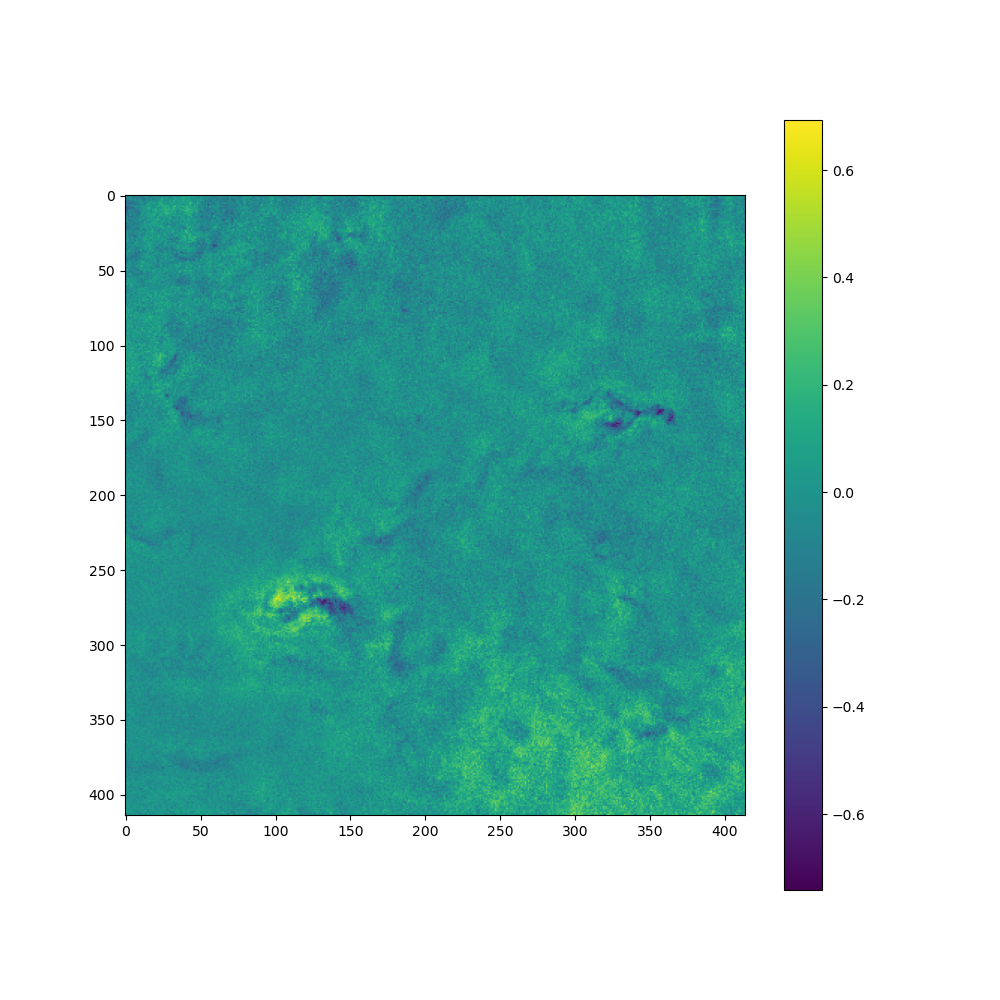

In [17]:
diff,_,_ = compareImages(filename_fsi, filename_hri, best_offset_crval1, best_offset_crval2)

plt.figure()
plt.imshow(diff)
plt.colorbar()


Yes, the difference image looks quite a bit better and more uniform and has lower range of values. As we expected, the result is not perfect though. Let's see if we can refine our results a bit.

In [18]:
best_offset_crval1, best_offset_crval2, best_diff = searchCrvalOffset(best_offset_crval1,best_offset_crval2, jump=2, around=2)

Offset for CRVAL1 11.00	CRVAL2 -19.00	Difference 14119.31	Huzzah, this should be the best offset yet!
Offset for CRVAL1 11.00	CRVAL2 -17.00	Difference 12632.71	Huzzah, this should be the best offset yet!
Offset for CRVAL1 11.00	CRVAL2 -15.00	Difference 12246.25	Huzzah, this should be the best offset yet!
Offset for CRVAL1 11.00	CRVAL2 -13.00	Difference 13238.04	
Offset for CRVAL1 11.00	CRVAL2 -11.00	Difference 15162.52	
Offset for CRVAL1 13.00	CRVAL2 -19.00	Difference 13672.73	
Offset for CRVAL1 13.00	CRVAL2 -17.00	Difference 12171.02	Huzzah, this should be the best offset yet!
Offset for CRVAL1 13.00	CRVAL2 -15.00	Difference 11863.74	Huzzah, this should be the best offset yet!
Offset for CRVAL1 13.00	CRVAL2 -13.00	Difference 13008.45	
Offset for CRVAL1 13.00	CRVAL2 -11.00	Difference 15095.00	
Offset for CRVAL1 15.00	CRVAL2 -19.00	Difference 13815.96	
Offset for CRVAL1 15.00	CRVAL2 -17.00	Difference 12481.21	
Offset for CRVAL1 15.00	CRVAL2 -15.00	Difference 12334.77	
Offset for CRVAL1 

This should be even better; a CRVAL1 offset of 13 and CRVAL2 offset of -15. We can refine the results even more. Enhance!

In [19]:
best_offset_crval1, best_offset_crval2, best_diff = searchCrvalOffset(best_offset_crval1,best_offset_crval2, jump=0.5, around=2)

Offset for CRVAL1 12.00	CRVAL2 -16.00	Difference 11943.02	Huzzah, this should be the best offset yet!
Offset for CRVAL1 12.00	CRVAL2 -15.50	Difference 11897.75	Huzzah, this should be the best offset yet!
Offset for CRVAL1 12.00	CRVAL2 -15.00	Difference 11950.85	
Offset for CRVAL1 12.00	CRVAL2 -14.50	Difference 12096.71	
Offset for CRVAL1 12.00	CRVAL2 -14.00	Difference 12335.30	
Offset for CRVAL1 12.50	CRVAL2 -16.00	Difference 11858.37	Huzzah, this should be the best offset yet!
Offset for CRVAL1 12.50	CRVAL2 -15.50	Difference 11819.83	Huzzah, this should be the best offset yet!
Offset for CRVAL1 12.50	CRVAL2 -15.00	Difference 11880.67	
Offset for CRVAL1 12.50	CRVAL2 -14.50	Difference 12034.91	
Offset for CRVAL1 12.50	CRVAL2 -14.00	Difference 12281.27	
Offset for CRVAL1 13.00	CRVAL2 -16.00	Difference 11828.69	
Offset for CRVAL1 13.00	CRVAL2 -15.50	Difference 11795.64	Huzzah, this should be the best offset yet!
Offset for CRVAL1 13.00	CRVAL2 -15.00	Difference 11863.74	
Offset for CRVAL1 

Enhance more!

In [20]:
best_offset_crval1, best_offset_crval2, best_diff = searchCrvalOffset(best_offset_crval1,best_offset_crval2, jump=0.2, around=2)

Offset for CRVAL1 12.60	CRVAL2 -15.90	Difference 11836.19	Huzzah, this should be the best offset yet!
Offset for CRVAL1 12.60	CRVAL2 -15.70	Difference 11805.67	Huzzah, this should be the best offset yet!
Offset for CRVAL1 12.60	CRVAL2 -15.50	Difference 11810.25	
Offset for CRVAL1 12.60	CRVAL2 -15.30	Difference 11791.19	Huzzah, this should be the best offset yet!
Offset for CRVAL1 12.60	CRVAL2 -15.10	Difference 11848.88	
Offset for CRVAL1 12.80	CRVAL2 -15.90	Difference 11794.25	
Offset for CRVAL1 12.80	CRVAL2 -15.70	Difference 11764.28	Huzzah, this should be the best offset yet!
Offset for CRVAL1 12.80	CRVAL2 -15.50	Difference 11769.41	
Offset for CRVAL1 12.80	CRVAL2 -15.30	Difference 11750.48	Huzzah, this should be the best offset yet!
Offset for CRVAL1 12.80	CRVAL2 -15.10	Difference 11809.87	
Offset for CRVAL1 13.00	CRVAL2 -15.90	Difference 11818.35	
Offset for CRVAL1 13.00	CRVAL2 -15.70	Difference 11788.91	
Offset for CRVAL1 13.00	CRVAL2 -15.50	Difference 11795.64	
Offset for CRVAL1 

In [21]:
best_offset_crval1, best_offset_crval2, best_diff = searchCrvalOffset(best_offset_crval1,best_offset_crval2, jump=0.1, around=2)

Offset for CRVAL1 12.60	CRVAL2 -15.50	Difference 11810.25	Huzzah, this should be the best offset yet!
Offset for CRVAL1 12.60	CRVAL2 -15.40	Difference 11818.29	
Offset for CRVAL1 12.60	CRVAL2 -15.30	Difference 11791.19	Huzzah, this should be the best offset yet!
Offset for CRVAL1 12.60	CRVAL2 -15.20	Difference 11828.58	
Offset for CRVAL1 12.60	CRVAL2 -15.10	Difference 11848.88	
Offset for CRVAL1 12.70	CRVAL2 -15.50	Difference 11803.00	
Offset for CRVAL1 12.70	CRVAL2 -15.40	Difference 11811.60	
Offset for CRVAL1 12.70	CRVAL2 -15.30	Difference 11784.36	Huzzah, this should be the best offset yet!
Offset for CRVAL1 12.70	CRVAL2 -15.20	Difference 11821.71	
Offset for CRVAL1 12.70	CRVAL2 -15.10	Difference 11842.70	
Offset for CRVAL1 12.80	CRVAL2 -15.50	Difference 11769.41	Huzzah, this should be the best offset yet!
Offset for CRVAL1 12.80	CRVAL2 -15.40	Difference 11777.75	
Offset for CRVAL1 12.80	CRVAL2 -15.30	Difference 11750.48	Huzzah, this should be the best offset yet!
Offset for CRVAL1 

Enough enhancing... Let's have a quick peek at the results.

<IPython.core.display.Javascript object>


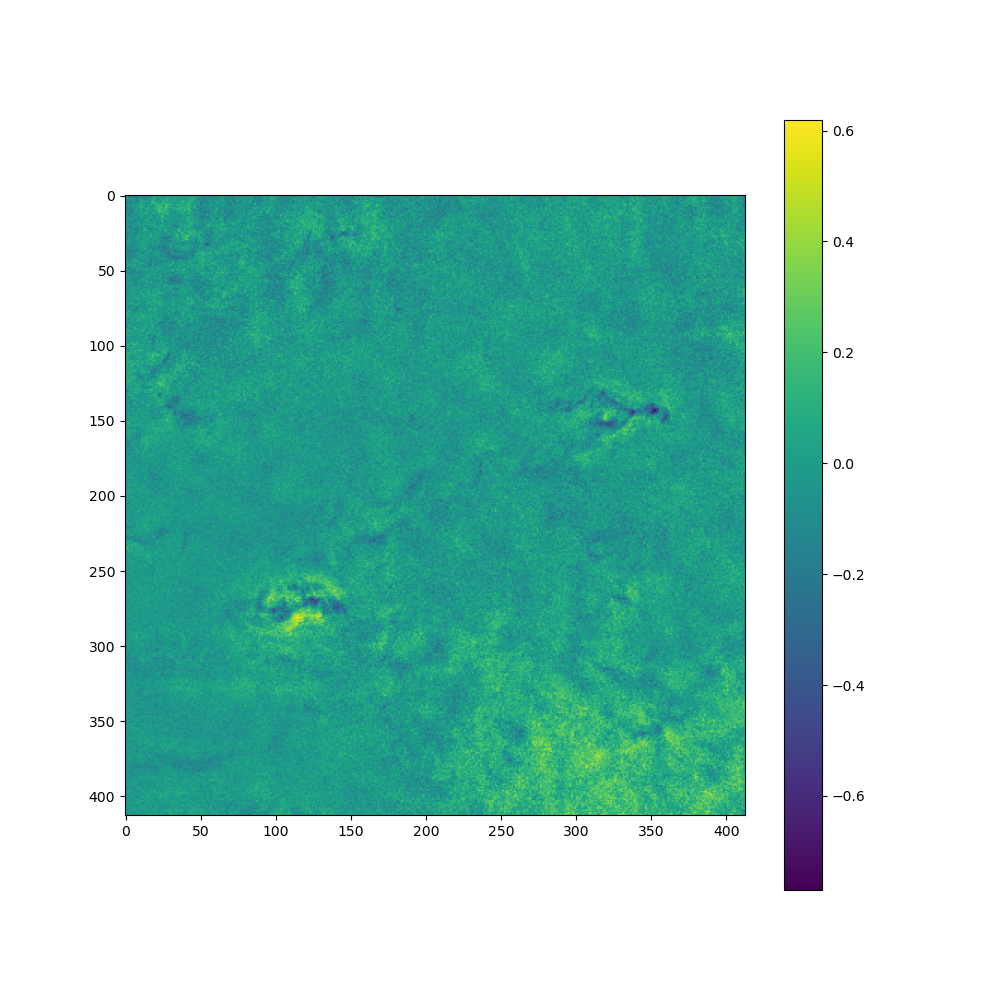

In [22]:
diff,_,_ = compareImages(filename_fsi, filename_hri, best_offset_crval1, best_offset_crval2)

plt.figure()
plt.imshow(diff)
plt.colorbar()


And indeed the difference image looks good! Now let's apply this offset and go back to a direct comparison between the FSI and corrected HRI EUV recording.

<IPython.core.display.Javascript object>


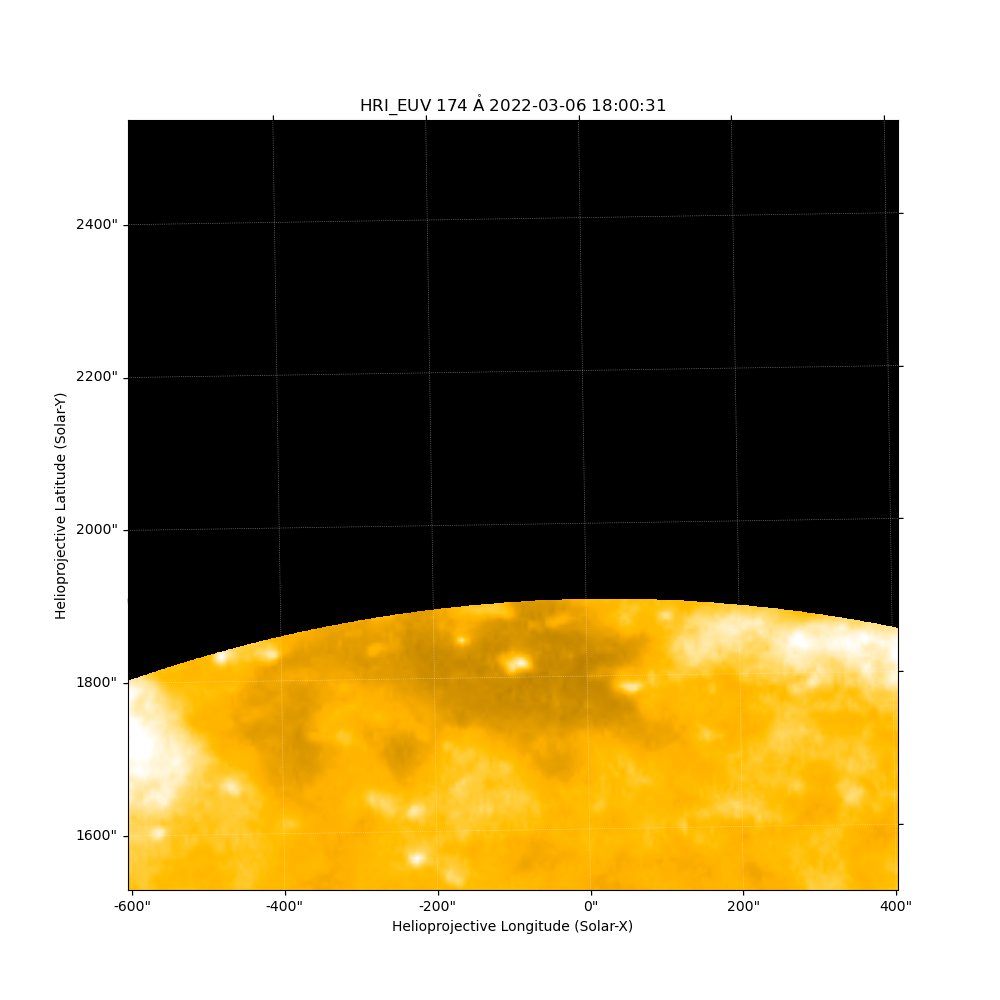

In [23]:
filename_fsi = './data_align/solo_L2_eui-fsi174-image_20220306T180030298_V01.fits'
filename_hri = './data_align/solo_L2_eui-hrieuv174-image_20220306T180030294_V01.fits'

hdu = fits.open(filename_hri)
hdu[-1].header['CRVAL1'] += best_offset_crval1
hdu[-1].header['CRVAL2'] += best_offset_crval2
mhri = sunpy.map.Map((hdu[-1].data, hdu[-1].header))

compare(sunpy.map.Map(filename_fsi), mhri, 'fsi_vs_hrieuv_fixed.gif')

![SegmentLocal](fsi_vs_hrieuv_fixed.gif "segment")


Nice. There is no visible mis-alignment anymore, we corrected the HRI EUV CRVAL values, and this with ~0.1 arc seconds accuracy!

This method was rather slow, but there is plenty of opportunity to make this go faster:
- algorithm improvements with for example a guided search in the difference landscape
- working directly with integer offsets without having to use reprojection
- other code optimizations such that we are not just blindly creating a new SunPy map every time, 
- etc.

We could further automate a procedure like this such that we can systemically have improved pointing information in our HRI EUV files (and LYA data) by comparing them to FSI 174 (and perhaps FSI 304) images. 

Of course one obvious downside of this method, is that the reference FSI images need to exist and they need to be taken close in time to the high resolution images, as we've seen in a previous part of these tutorials that thermo-elastic effects affect the pointing accuracy on a time-scale of less than an hour. 